<a href="https://colab.research.google.com/github/danieldai/Dive-into-DL-PyTorch-in-Colab/blob/main/3_6_softmax%E5%9B%9E%E5%BD%92%E7%9A%84%E4%BB%8E%E9%9B%B6%E5%BC%80%E5%A7%8B%E5%AE%9E%E7%8E%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://tangshusen.me/Dive-into-DL-PyTorch/#/chapter03_DL-basics/3.6_softmax-regression-scratch

下载 d2lzh_pytorch 到colab环境中

In [1]:
!git clone https://github.com/ShusenTang/Dive-into-DL-PyTorch.git
#!ls Dive-into-DL-PyTorch/code/d2lzh_pytorch
!cp -r Dive-into-DL-PyTorch/code/d2lzh_pytorch /content

fatal: destination path 'Dive-into-DL-PyTorch' already exists and is not an empty directory.


# 3.6 softmax回归的从零开始实现

这一节我们来动手实现softmax回归。首先导入本节实现所需的包或模块。

In [2]:
import torchtext
torchtext.disable_torchtext_deprecation_warning()

import torch
import torchvision
import numpy as np
import sys
sys.path.append("..") # 为了导入上层目录的d2lzh_pytorch
import d2lzh_pytorch as d2l



## 3.6.1 获取和读取数据

我们将使用Fashion-MNIST数据集，并设置批量大小为256。

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, root='/content/Datasets/FashionMNIS')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3.6.2 初始化模型参数
跟线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本输入是高和宽均为28像素的图像。模型的输入向量的长度是 $28 \times 28 = 784$：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为$784 \times 10$和$1 \times 10$的矩阵。

In [4]:
num_inputs = 784
num_outputs = 10

W = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)


同之前一样，我们需要模型参数梯度。

In [5]:
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 3.6.3 实现softmax运算

在介绍如何定义softmax回归之前，我们先描述一下对如何对多维`Tensor`按维度操作。在下面的例子中，给定一个`Tensor`矩阵`X`。我们可以只对其中同一列（`dim=0`）或同一行（`dim=1`）的元素求和，并在结果中保留行和列这两个维度（`keepdim=True`）。

In [6]:
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


下面我们就可以定义前面小节里介绍的softmax运算了。在下面的函数中，矩阵`X`的行数是样本数，列数是输出个数。为了表达样本预测各个输出的概率，softmax运算会先通过`exp`函数对每个元素做指数运算，再对`exp`矩阵同行元素求和，最后令矩阵每行各元素与该行元素之和相除。这样一来，最终得到的矩阵每行元素和为1且非负。因此，该矩阵每行都是合法的概率分布。softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。

In [7]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(dim=1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制


可以看到，对于随机输入，我们将每个元素变成了非负数，且每一行和为1。

In [8]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1564, 0.2029, 0.2150, 0.2117, 0.2139],
        [0.2624, 0.1088, 0.2014, 0.1779, 0.2495]]) tensor([1.0000, 1.0000])


## 3.6.4 定义模型

有了softmax运算，我们可以定义上节描述的softmax回归模型了。这里通过`view`函数将每张原始图像改成长度为`num_inputs`的向量。

In [9]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W) + b)


## 3.6.5 定义损失函数

上一节中，我们介绍了softmax回归使用的交叉熵损失函数。为了得到标签的预测概率，我们可以使用`gather`函数。在下面的例子中，变量`y_hat`是2个样本在3个类别的预测概率，变量`y`是这2个样本的标签类别。通过使用`gather`函数，我们得到了2个样本的标签的预测概率。与3.4节（softmax回归）数学表述中标签类别离散值从1开始逐一递增不同，在代码中，标签类别的离散值是从0开始逐一递增的。

In [10]:
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))


tensor([[0.1000],
        [0.5000]])

下面实现了3.4节（softmax回归）中介绍的交叉熵损失函数。

In [11]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))


## 3.6.6 计算分类准确率

给定一个类别的预测概率分布`y_hat`，我们把预测概率最大的类别作为输出类别。如果它与真实类别`y`一致，说明这次预测是正确的。分类准确率即正确预测数量与总预测数量之比。

为了演示准确率的计算，下面定义准确率`accuracy`函数。其中`y_hat.argmax(dim=1)`返回矩阵`y_hat`每行中最大元素的索引，且返回结果与变量`y`形状相同。相等条件判断式`(y_hat.argmax(dim=1) == y)`是一个类型为`ByteTensor`的`Tensor`，我们用`float()`将其转换为值为0（相等为假）或1（相等为真）的浮点型`Tensor`。

In [12]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()


让我们继续使用在演示`gather`函数时定义的变量`y_hat`和`y`，并将它们分别作为预测概率分布和标签。可以看到，第一个样本预测类别为2（该行最大元素0.6在本行的索引为2），与真实标签0不一致；第二个样本预测类别为2（该行最大元素0.5在本行的索引为2），与真实标签2一致。因此，这两个样本上的分类准确率为0.5。

In [13]:
print(accuracy(y_hat, y))

0.5


类似地，我们可以评价模型`net`在数据集`data_iter`上的准确率。

In [14]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n


因为我们随机初始化了模型`net`，所以这个随机模型的准确率应该接近于类别个数10的倒数即0.1。

In [15]:
print(evaluate_accuracy(test_iter, net))

0.186


## 3.6.7 训练模型

训练softmax回归的实现跟3.2（线性回归的从零开始实现）一节介绍的线性回归中的实现非常相似。我们同样使用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数`num_epochs`和学习率`lr`都是可以调的超参数。改变它们的值可能会得到分类更准确的模型。

In [16]:
num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)


epoch 1, loss 0.7844, train acc 0.750, test acc 0.793
epoch 2, loss 0.5701, train acc 0.813, test acc 0.811
epoch 3, loss 0.5260, train acc 0.826, test acc 0.821
epoch 4, loss 0.5016, train acc 0.832, test acc 0.819
epoch 5, loss 0.4850, train acc 0.837, test acc 0.822


## 3.6.8 预测

训练完成后，现在就可以演示如何对图像进行分类了。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


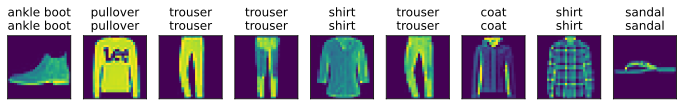

In [18]:
for X, y in iter(test_iter):

  true_labels = d2l.get_fashion_mnist_labels(y.numpy())
  pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
  titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

  d2l.show_fashion_mnist(X[0:9], titles[0:9])
  break


## 小结

* 可以使用softmax回归做多类别分类。与训练线性回归相比，你会发现训练softmax回归的步骤和它非常相似：获取并读取数据、定义模型和损失函数并使用优化算法训练模型。事实上，绝大多数深度学习模型的训练都有着类似的步骤。

-----------
> 注：本节除了代码之外与原书基本相同，[原书传送门](https://zh.d2l.ai/chapter_deep-learning-basics/softmax-regression-scratch.html)